In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy

# Item VI

A *simple ODE*
* Design a numerical method to approximate the following Boundary Value Problem:
$$
\epsilon y''(x) + (1+\epsilon) y'(x) + y(x) = 0 \qquad \text{for $0<x<1$ and $y(0)=0, y(1)=1$.}
$$
* Plot the numerical approximation against its analytical solution for $\epsilon = 1, 10^{-3}, 10^{-8},$ and $10^{-14}$. 
* Is your numerical approximation valid for all $x$?
* Is your approximation accurate?
---

In [2]:
def newton(yp=lambda y,t:1,yi=0,tmin=0,tmax=1.0,steps=400):
    delta = (tmax-tmin)/float(steps)
    t = tmin
    ys = []
    ys.append(yi)
    for i in range(steps):
        t = tmin+delta*i
        yp_next = yp(ys[-1],t)
        y_next = ys[-1]+delta*yp_next
        ys.append(y_next)
    return ys

In [3]:
# Let's use shooting method:
def shooting(equ=lambda y,yp,t:1,yi=0,yf=0,
                ypa=0,ypb=1e3,yp_precision=1e-9,
                tmin=0.0,tmax=1.0,steps=400):
    # function for newton's method
    shooteval = lambda y,t: np.array([y[1],equ(y[0],y[1],t)])
    # Check y(ypa) and y(ypb)
    yf_ypa = newton(shooteval,yi=np.array([yi,ypa]),
                    tmin=tmin,tmax=tmax,steps=steps)[-1][0]
    yf_ypb = newton(shooteval,yi=np.array([yi,ypb]),
                    tmin=tmin,tmax=tmax,steps=steps)[-1][0]
    # Find y'(t0) through bisection
    while np.abs(ypb-ypa)>yp_precision:
        # Couldn't find root
        if np.isnan(yf_ypa) or np.isnan(yf_ypb) or (yf_ypa-yf)*(yf_ypb-yf)>0:
            return None
        # print("y'_a(0)=%f y'_b(0)=%f"%(ypa,ypb))
        ypc = (ypa+ypb)/2.0
        ys = newton(shooteval,yi=np.array([yi,ypc]),
                    tmin=tmin,tmax=tmax,steps=steps)
        yf_ypc = ys[-1][0]
        if (yf_ypc-yf)==0:
            return ys
        elif (yf_ypa-yf)*(yf_ypc-yf)<0:
            yf_ypb = yf_ypc
            ypb = ypc
        else:
            yf_ypa = yf_ypc
            ypa = ypc
    return ys

In [4]:
def problem_ode(e):
    fn = lambda y,yp,t: -(1.0+e)/e*yp-1.0/e*y
    return fn

In [5]:
STEPS = 400
E = [1,0.2,0.1,0.01,1e-3,1e-8,1e-14]

xs = np.linspace(0,1,num=STEPS+1)

yss_numerical = {}
for e in E:
    print("Computing epsilon=%s."%e)
    ys = shooting(problem_ode(e),yi=0,yf=1,ypa=1.0,ypb=50.0,steps=STEPS)
    if ys is not None:
        yss_numerical[str(e)] = [y[0] for y in ys]
    else:
        print("  Couldn't find y'(0) for epsilon=%s"%e)

Computing epsilon=1.
Computing epsilon=0.2.
Computing epsilon=0.1.
Computing epsilon=0.01.
  Couldn't find y'(0) for epsilon=0.01
Computing epsilon=0.001.
  Couldn't find y'(0) for epsilon=0.001
Computing epsilon=1e-08.
  Couldn't find y'(0) for epsilon=1e-08
Computing epsilon=1e-14.
  Couldn't find y'(0) for epsilon=1e-14


/home/fcasas/Music/p36cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  
/home/fcasas/Music/p36cpu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in add
  if __name__ == '__main__':
/home/fcasas/Music/p36cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


With the coded method the solution couldn't be found once $\epsilon$ became small enough.

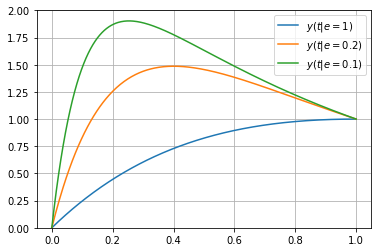

In [6]:
for name,ys in yss_numerical.items():
    plt.plot(xs,ys,label="$y(t|e=%s)$"%name)
plt.legend()
plt.ylim((0,2))
plt.grid()
plt.show()

We find the analytical solution now:

In [7]:
def get_analytical_solution(ee,xs,n=200):
    x = sympy.Symbol("x")
    y = sympy.Function("y")(x)
    y_ = sympy.Derivative(y,x)
    y__ = sympy.Derivative(y_,x)
    sol = sympy.dsolve(
        ee * y__ + (1+ee) * y_ + y, y, ics={y.subs(x,0):0,y.subs(x,1):1})
    sol = sol.rhs
    return [float(sol.subs(x,xx)) for xx in np.linspace(0,1,num=n+1)]

computing for epsilon=1
computing for epsilon=0.2
computing for epsilon=0.1
computing for epsilon=0.01
computing for epsilon=0.001


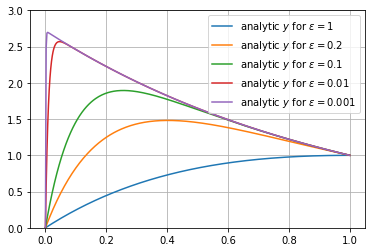

In [8]:
yss_analytical = {}
for e in E:
    if e<1e-6: continue # Smaller values take forever.
    print("computing for epsilon=%s"%e)
    ys = get_analytical_solution(e,xs,n=STEPS)
    yss_analytical[str(e)] = ys
    plt.plot(xs,ys,label="analytic $y$ for $\epsilon=%s$"%e)
plt.legend()
plt.ylim((0,3))
plt.grid()
plt.show()

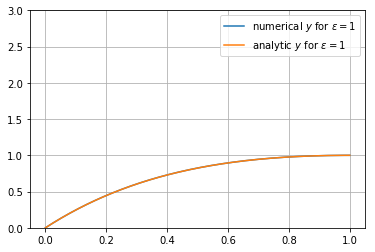

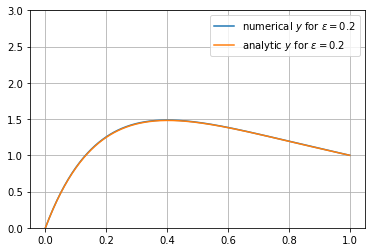

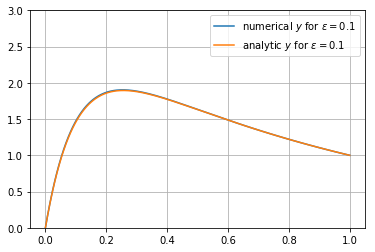

In [9]:
# Plot the analytic solution and the numerical one for the cases when we have both.
for ee_name in yss_numerical:
    if ee_name in yss_analytical:
        plt.plot(xs,yss_numerical[ee_name],label="numerical $y$ for $\epsilon=%s$"%ee_name)
        plt.plot(xs,yss_analytical[ee_name],label="analytic $y$ for $\epsilon=%s$"%ee_name)
        plt.legend()
        plt.ylim((0,3))
        plt.grid()
        plt.show()

The approximation seems almost identical for all $0<x<1$ for the $\epsilon$'s for which the problem could be solved. However, picking *shooting method* and bisection probably was a poor choice, since as $\epsilon$ gets smaller, $y'(0)$ (which must be found) becomes larger ($\epsilon \rightarrow 0 \Rightarrow y'(0) \rightarrow \infty$) very fast, so it's value becomes harder to find.

In [10]:
# Measure the maximum error between the numerical and analytical solutions:
for ee_name in yss_numerical:
    if ee_name in yss_analytical:
        max_error = np.max(np.abs(np.array(yss_numerical[ee_name])-yss_analytical[ee_name]))
        print("max error for epsilon=%5s: %f"%(ee_name,max_error))

max error for epsilon=    1: 0.000549
max error for epsilon=  0.2: 0.006706
max error for epsilon=  0.1: 0.014160


It can be see that the error isn't larger than $0.015$ for the $\epsilon$ for which the problem could be solved with the method used.

<!-- Go for the perturbation approach -->